In [162]:
import os
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import plotly.graph_objects as go
import numpy as np

In [163]:
# Initialize variables to store the aggregated results
aggregated_results = {
    'true_positives': 0,
    'false_positives': 0,
    'true_negatives': 0,
    'false_negatives': 0,
    'f1_score': 0,
    'precision': 0,
    'recall': 0,
}


In [164]:
def EDA_transformation(df):
    # Step 1: Logarithmic transformation of 'recon_losses'
    df['transformed_recon_losses'] = np.log(df['recon_losses_SMA'] + 1e-9)
    
    # Step 2: Combine 'kmeans_anomaly_score' and 'lstm_error' using a simple average
    df['combined_kmeans_and_lstm'] = (df['kmeans_anomaly_score_SMA'] + df['lstm_error_SMA']) / 2

    # Step 3: concatenate 'actual_anomaly' from df
    df['actual_anomaly'] = df['actual_anomaly']

    # Display the first few rows of the transformed and combined columns for verification
    scaler = MinMaxScaler()
    df['transformed_recon_losses'] = scaler.fit_transform(df[['transformed_recon_losses']])
    df['combined_kmeans_and_lstm'] = scaler.fit_transform(df[['combined_kmeans_and_lstm']])

    # Separate the data into normal and anomaly
    df_normal = df[df['actual_anomaly'] == 0]
    df_anomaly = df[df['actual_anomaly'] == 1]

    # Make plot with 'transformed_recon_losses' on x axis and 'combined_kmeans_and_lstm' on y axis
    # Add separate traces for normal and anomaly data
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df_normal['transformed_recon_losses'], y=df_normal['combined_kmeans_and_lstm'], mode='markers', name='Normal'))
    fig.add_trace(go.Scatter(x=df_anomaly['transformed_recon_losses'], y=df_anomaly['combined_kmeans_and_lstm'], mode='markers', name='Anomaly'))
    fig.update_layout(title='Transformed Recon Losses vs Combined Kmeans and LSTM', xaxis_title='Log transformation Reconstruction Anomaly Score', yaxis_title='Combined K-means and LSTM Anomaly Score')
    fig.show()
    return df


In [165]:
def plot(final_df):
    # Plot the anomaly score
    scaler = MinMaxScaler()
    final_df[['kmeans_anomaly_score_SMA', 'recon_losses_SMA', 'lstm_error_SMA']] = scaler.fit_transform(final_df[['kmeans_anomaly_score_SMA', 'recon_losses_SMA', 'lstm_error_SMA']])

    x = final_df['kmeans_anomaly_score_SMA']
    y = final_df['recon_losses_SMA']
    z = final_df['lstm_error_SMA']
    color = final_df['actual_anomaly']  # Assuming this is categorical
    
    # Define your mapping
    legend_mapping = {0.0: 'Normal', 1.0: 'Anomaly'}
    
    # Create a 3D scatter plot with separate traces for each category in 'color'
    fig = go.Figure()
    for category in color.unique():
        fig.add_trace(go.Scatter3d(
            x=x[color == category],
            y=y[color == category],
            z=z[color == category],
            mode='markers',
            name=legend_mapping.get(category, str(category)),  # Use the mapping for the trace name
            marker=dict(
                size=6,
                color=category,
                colorscale='Viridis',
                opacity=0.8
            )
        ))

    # Set the title and labels
    fig.update_layout(scene=dict(
                        xaxis_title='Kmeans Anomaly Score',
                        yaxis_title='Recon Losses',
                        zaxis_title='LSTM Error'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10),
                    legend_title="Legend Title")
    fig.update_layout(showlegend=True)
    # Display the plot
    fig.show()

In [166]:
def apply_smooting(df):
    class_column = df['actual_anomaly']
    df = df.drop(columns=['actual_anomaly'])
    # Set the window size for the moving average
    window_size = 200  # You can change this value as per your requirement

    # Apply simple moving average and fill NaN values with the original values
    for column in df.columns:
        df[column + '_SMA'] = df[column].rolling(window=window_size).mean().fillna(df[column])

    return pd.concat([df, class_column], axis=1)


In [167]:
from sklearn.neighbors import NearestNeighbors
def perform_thresholding(final_df):
    X = final_df[['combined_kmeans_and_lstm']].values
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    # print('Here is the dataframe of combined anomaly scores')
    # print(pd.DataFrame(X,columns=['kmeans anomaly score', 'recon losses','lstm error']))
    nbrs = NearestNeighbors(n_neighbors=7000)
    nbrs.fit(X)
    distances, indices = nbrs.kneighbors(X)

    threshold = np.mean(distances)

    predicted_labels = np.where(distances.mean(axis=1) > threshold, 1, 0)
    final_df['predicted_labels'] = predicted_labels
    
    return final_df

In [168]:
activation_function = 'relu'
parent_dir = os.getcwd()
csv_folder = os.path.join(parent_dir,'..','data','processed',activation_function)

In [169]:
df = pd.read_csv(os.path.join(csv_folder, f'D-1_{activation_function}_final_df.csv'))

In [170]:
df = apply_smooting(df)
print(df.head())

   recon_losses  kmeans_anomaly_score  lstm_error  recon_losses_SMA  \
0      0.028054              1.606666         0.0          0.028054   
1      0.028054              1.606666         0.0          0.028054   
2      0.028054              1.606666         0.0          0.028054   
3      0.028054              1.606666         0.0          0.028054   
4      0.028054              1.606666         0.0          0.028054   

   kmeans_anomaly_score_SMA  lstm_error_SMA  actual_anomaly  
0                  1.606666             0.0             0.0  
1                  1.606666             0.0             0.0  
2                  1.606666             0.0             0.0  
3                  1.606666             0.0             0.0  
4                  1.606666             0.0             0.0  


In [171]:
plot(df)

In [172]:
df.head()

,recon_losses,kmeans_anomaly_score,lstm_error,recon_losses_SMA,kmeans_anomaly_score_SMA,lstm_error_SMA,actual_anomaly
0,0.028054,1.606666,0.0,1.549467e-27,0.012135,0.0,0.0
1,0.028054,1.606666,0.0,1.549466e-27,0.012135,0.0,0.0
2,0.028054,1.606666,0.0,1.549467e-27,0.012135,0.0,0.0
3,0.028054,1.606666,0.0,1.549468e-27,0.012135,0.0,0.0
4,0.028054,1.606666,0.0,1.549468e-27,0.012135,0.0,0.0


In [173]:
# Dropping the 'Unnamed: 0' column
eda_data_dropped = df[['recon_losses_SMA','kmeans_anomaly_score_SMA','lstm_error_SMA']]

# Statistical summary of the modified dataset
statistical_summary_dropped = eda_data_dropped.describe()

# Distribution and skewness of each column in the modified dataset
skewness_dropped = eda_data_dropped.skew()

# Correlation analysis on the modified dataset
correlation_matrix_dropped = eda_data_dropped.corr()

statistical_summary_dropped, skewness_dropped, correlation_matrix_dropped

(       recon_losses_SMA  kmeans_anomaly_score_SMA  lstm_error_SMA
 count      8.509000e+03               8509.000000     8509.000000
 mean       2.350452e-02                  0.084667        0.058318
 std        1.378336e-01                  0.164394        0.164035
 min        0.000000e+00                  0.000000        0.000000
 25%        1.248150e-27                  0.012803        0.001308
 50%        3.439374e-27                  0.021311        0.002282
 75%        6.344800e-25                  0.119971        0.063326
 max        1.000000e+00                  1.000000        1.000000,
 recon_losses_SMA            6.195541
 kmeans_anomaly_score_SMA    3.739383
 lstm_error_SMA              4.157144
 dtype: float64,
                           recon_losses_SMA  kmeans_anomaly_score_SMA  \
 recon_losses_SMA                  1.000000                 -0.080119   
 kmeans_anomaly_score_SMA         -0.080119                  1.000000   
 lstm_error_SMA                   -0.059019   

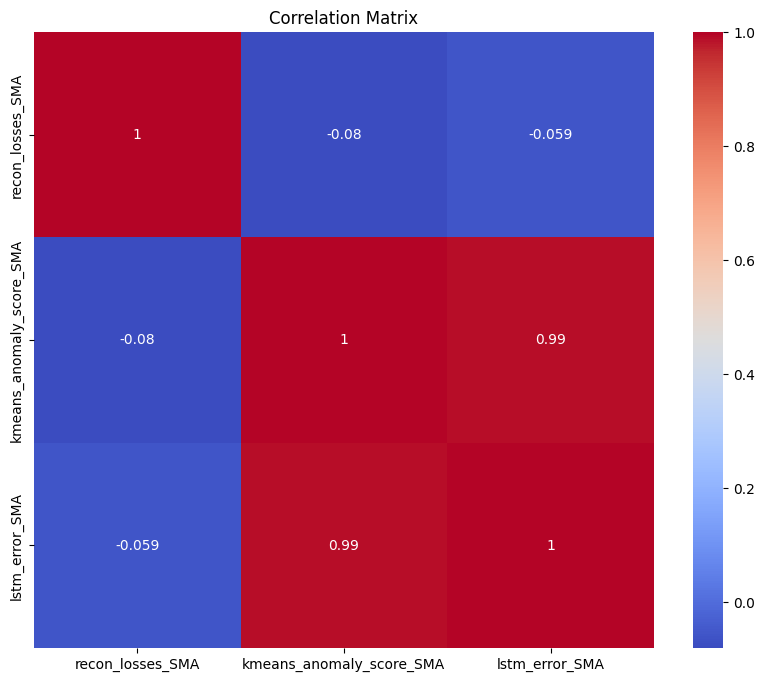

In [174]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_dropped, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [175]:
df = EDA_transformation(df)
df.tail()

,recon_losses,kmeans_anomaly_score,lstm_error,recon_losses_SMA,kmeans_anomaly_score_SMA,lstm_error_SMA,actual_anomaly,transformed_recon_losses,combined_kmeans_and_lstm
8504,8.250591,11.591382,0.451264,6.377296e-25,0.159937,0.096763,1.0,0.0,0.128369
8505,8.251242,10.989969,0.452510,6.377689e-25,0.159700,0.096591,1.0,0.0,0.128165
8506,8.251932,10.816828,0.453307,6.378083e-25,0.159453,0.096396,1.0,0.0,0.127943
8507,8.252650,10.707556,0.454148,6.378478e-25,0.159141,0.096174,1.0,0.0,0.127677
8508,8.253231,10.534997,0.449025,6.378872e-25,0.158824,0.095919,1.0,0.0,0.127391


In [176]:
new_df = df[['transformed_recon_losses','combined_kmeans_and_lstm']]
new_df

,transformed_recon_losses,combined_kmeans_and_lstm
0,0.0,0.006068
1,0.0,0.006068
2,0.0,0.006068
3,0.0,0.006068
4,0.0,0.006068
...,...,...
8504,0.0,0.128369
8505,0.0,0.128165
8506,0.0,0.127943
8507,0.0,0.127677


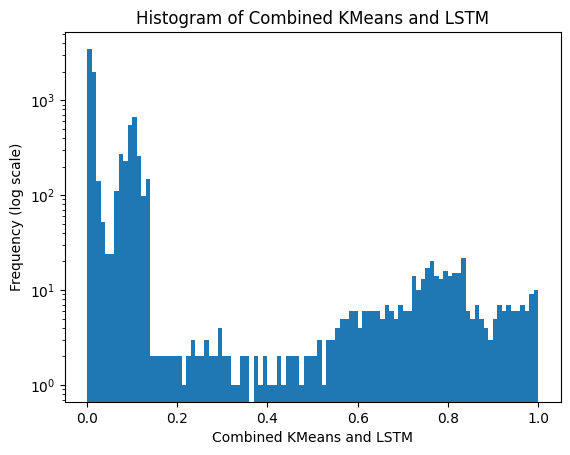

In [177]:
import matplotlib.pyplot as plt

# Let's examine the 'combined_kmeans_and_lstm' distribution and determine potential thresholds.
plt.hist(df['combined_kmeans_and_lstm'], bins=100, log=True)
plt.title('Histogram of Combined KMeans and LSTM')
plt.xlabel('Combined KMeans and LSTM')
plt.ylabel('Frequency (log scale)')
plt.show()

# Calculate thresholds at various percentiles
threshold = df['combined_kmeans_and_lstm'].quantile(0.652)

# Create a new column 'predicted_labels' where the value is 1 if 'combined_kmeans_and_lstm' is greater than the threshold, and 0 otherwise
df['predicted_labels'] = (df['combined_kmeans_and_lstm'] > threshold).astype(int)


In [178]:
print(threshold)

0.021868774294304196


In [179]:
# Calculate confusion matrix and extract TP, FP, TN, FN
tn, fp, fn, tp = confusion_matrix(df['actual_anomaly'], df['predicted_labels'].astype(int)).ravel()

# Aggregate the results
aggregated_results['true_positives'] += tp
aggregated_results['false_positives'] += fp
aggregated_results['true_negatives'] += tn
aggregated_results['false_negatives'] += fn
# Calculate precision, recall, and F1 score
aggregated_results['precision'] = aggregated_results['true_positives'] / (aggregated_results['true_positives'] + aggregated_results['false_positives'])
aggregated_results['recall'] = aggregated_results['true_positives'] / (aggregated_results['true_positives'] + aggregated_results['false_negatives'])
aggregated_results['f1_score'] = 2 * (aggregated_results['precision'] * aggregated_results['recall']) / (aggregated_results['precision'] + aggregated_results['recall'])

In [180]:
aggregated_results

{'true_positives': 2961,
 'false_positives': 0,
 'true_negatives': 5250,
 'false_negatives': 298,
 'f1_score': 0.9520900321543407,
 'precision': 1.0,
 'recall': 0.9085609082540657}